In [ ]:
!pip install pyspark &> /dev/null

In [ ]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.rdd import RDD

In [ ]:
import random

# Number of random points to generate
num_points = 500

# Range for x and y coordinates
x_range = (-15, 15)
y_range = (-15, 15)

# Generate random integer points
points = [(random.randint(x_range[0], x_range[1]), random.randint(y_range[0], y_range[1])) for _ in range(num_points)]

# Write points to file
with open("data.txt", "w") as file:
    for point in points:
        file.write(f"{point[0]} {point[1]}\n")

In [ ]:
def to_tuple(point_str):
    x, y = map(int, point_str.split())
    return x, y

def to_sorted_points(x):
    return (x[0],) + tuple(sorted(set(x[1::])))


def non_duplicates(pair):
    return pair[0] != pair[1]

def get_cartesian(rdd):
    cartesian_rdd = rdd.cartesian(rdd)
    cartesian_rdd = cartesian_rdd.filter(non_duplicates)
    return cartesian_rdd

def find_distance(pair):
    (x1, y1), (x2, y2) = pair
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
    return ((x1, y1), distance), (x2, y2)

def find_equidistant(rdd):
    rdd = rdd.map(find_distance)
    grouped_rdd = rdd.map(lambda x: ((x[0][0], x[0][1]), (x[1],)))
    grouped_rdd = grouped_rdd.reduceByKey(lambda x, y: x + y)
    result_rdd = grouped_rdd.map(lambda x: ([x[0][0]]+ [v for v in x[1]]  ))
    result_rdd = result_rdd.map(to_sorted_points)
    result_rdd = result_rdd.filter(lambda x: len(x) >= 10)
    result_rdd = result_rdd.distinct()
    result_rdd = result_rdd.sortBy(lambda x: x[0][0])

    return result_rdd


In [ ]:
rdd = sc.textFile('data.txt')
rdd = rdd.map(to_tuple)
rdd = get_cartesian(rdd)
rdd = find_equidistant(rdd)

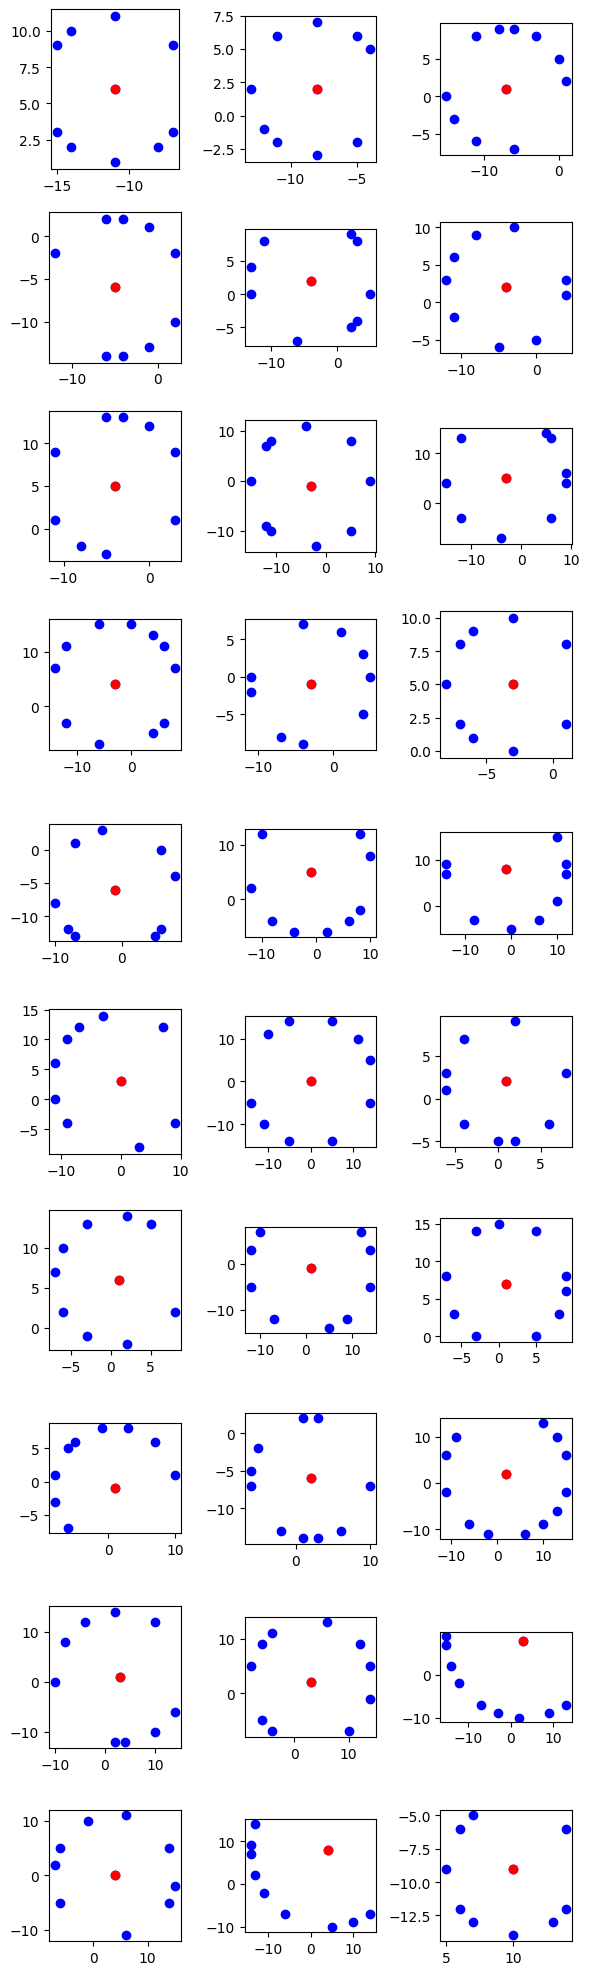

In [ ]:
import matplotlib.pyplot as plt

data = rdd.collect()
num_columns = 3  # Number of columns for subplots

num_plots = len(data)
num_rows = (num_plots + num_columns - 1) // num_columns  # Calculate number of rows needed

fig, axs = plt.subplots(num_rows, num_columns, figsize=(2*num_columns, 2*num_rows))

for i, sublist in enumerate(data):
    row = i // num_columns
    col = i % num_columns
    ax = axs[row, col]
    x_values, y_values = zip(*sublist)
    ax.plot(x_values, y_values, 'bo')  # Plot all points in blue
    ax.plot(x_values[0], y_values[0], 'ro')  # First point in red
    ax.set_aspect('equal')  # Set same scale for x and y axes

# Hide empty subplots if the number of plots is not a multiple of num_columns
if num_plots % num_columns != 0:
    for j in range(num_plots % num_columns, num_columns):
        fig.delaxes(axs[-1, j])

plt.tight_layout()
plt.show()
